# MIS581 Portfolio Project

Name: Carl J. Loucius
<br>Assignment: Project

##### Library & Dataset Import Statements

In [1]:
# List of library import statements for project
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from pandas.plotting import scatter_matrix
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV 
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

# Import the data into the dataframe
sales_df = pd.read_csv("PizzaSalesData.csv")

# Display the first five observations of the dataset
sales_df.head()

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,1/1/15,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/15,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/15,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/15,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/15,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [2]:
sales_df.shape

(48620, 12)

Based on the previous lines of code, the dataset has twelve columns and 48,620 rows. Each row corresponds to a specific quantity for a type of pizza ordered from an order (e.g., the first order shown in the above table has only one pizza on the order, while the second order has multiple pizzas on the same order). The dataset contains additional information about the type, name, and ingredients for the pizzas. Also, it contains information about the unit price, pizza size, and total price that was charged for that specific pizza on the order. Lastly, it contains information about the order date and time.

It is important to note that the above table does not work particularly well for my research questions since the grainularity of the data is too narrow (per order line on an order; or recording each transaction per second). If I would like to perform time series analysis on the data, then I will need to perform some aggregations to a different time aspect (hours, days, or months). Therefore, I must manipulate the dataset to prepare it for the purpose of my project.

##### Data Manipulation

The project will utilize the day as the standard time measurement. I will create a new dataset with the accumulation values of sales, vistors, and number of pizzas sold for each given day by using the information from the original dataset. After I create this modified dataset, I will be able to generate descriptive statistics, histograms, and some initial time series plots for my dataset.

In [3]:
# Create a new dataframe containing the total sales for each given day.
sales_df_daily_total = sales_df.groupby('order_date').agg({'total_price': 'sum'})
sales_df_daily_total = sales_df_daily_total.reset_index()

# Create a new dataframe containing the total number of orders for each given day by counting the number of unique order ids.
sales_df_daily_orders = sales_df.groupby('order_date').agg({'order_id': 'nunique'})
sales_df_daily_orders = sales_df_daily_orders.reset_index()

# Create a new dataframe containing the total number of pizzas sold for each given day.
sales_df_daily_pizza_qty = sales_df.groupby('order_date').agg({'quantity': 'sum'})
sales_df_daily_pizza_qty = sales_df_daily_pizza_qty.reset_index()

# Combine the three new dataframes into a single data frame with a join operation.
# Also, the column names in the new dataframe are changed to indicate what the values 
# actually represent.
sales_df_new_daily = pd.concat([sales_df_daily_total, sales_df_daily_orders['order_id'], sales_df_daily_pizza_qty['quantity']], axis = 1)
sales_df_new_daily.rename(columns = {'order_date':'Date','total_price':'Total Sales', 'order_id':'Total Orders', 'quantity':'Total Pizzas Sold'}, inplace=True)
sales_df_new_daily

,Date,Total Sales,Total Orders,Total Pizzas Sold
0,1/1/15,2713.85,69,162
1,1/10/15,2463.95,65,146
2,1/11/15,1872.30,52,116
3,1/12/15,1919.05,55,119
4,1/13/15,2049.60,48,120
...,...,...,...,...
353,9/5/15,2537.80,59,153
354,9/6/15,1491.65,47,92
355,9/7/15,2283.35,60,140
356,9/8/15,2249.50,61,133


The previous cell indicates that there are 358 rows. The dataset should have 365 rows to correspond to each day in 2015, so there are seven missing observations. The missing observations will be fixed beforehand. This project will fill the values for the "Total Sales", "Total Orders", and "Total Pizzas Sold" with the respective mean for each variable for the missing dates. This project will assume that the restaurant was open, but failed to record sales. There are options on how to handle this missing data (e.g., fill with 0 and assume the business was closed those dates).

The following code block will find the dates with missing values after first modifying the data frame for time series handling purposes.

In [4]:
# Convert the data column to the datetime data type. Then, the table was sorted 
# by the date values. Afterward, I had to set this as the new index for the dataframe.
sales_df_new_daily['Date'] = pd.to_datetime(sales_df_new_daily['Date'])
sales_df_new_daily = sales_df_new_daily.sort_values('Date', ascending = True)
sales_df_new_daily = sales_df_new_daily.set_index('Date')
sales_df_new_daily.head()

# Print the dates missing from the data frame.
print(pd.date_range(start="2015-01-01", end="2015-12-31").difference(sales_df_new_daily.index))

DatetimeIndex(['2015-09-24', '2015-09-25', '2015-10-05', '2015-10-12',
               '2015-10-19', '2015-10-26', '2015-12-25'],
              dtype='datetime64[ns]', freq=None)


According to the above output, we are missing values for the following dates: 9-24, 9-25, 10-5, 10-12, 10-19, 10-26, and 12-25. As mentioned previously, the values for each variable will be filled with 0 for these dates.

The following code creates a new data frame with the values for each of those dates. Then, it will combine this data frame with the original data frame. The resulting data frame will contain total sales, number of visitors, and total number of pizzas sold for each day.

In [5]:
# Set the missing values to the mean of the respective variables.
# Total sales was rounded to 2 decimal places, while the other two variables
# was rounded to an integer number.
missing_sales = round(sales_df_new_daily['Total Sales'].mean(), 2)
missing_orders = round(sales_df_new_daily['Total Orders'].mean(), 0)
missing_pizzas_sold = round(sales_df_new_daily['Total Pizzas Sold'].mean(), 0)

# Define a dictionary with the missing data
data_to_add = {
    "Date": ['2015-09-24', '2015-09-25', '2015-10-05', '2015-10-12', '2015-10-19',
            '2015-10-26', '2015-12-25'],
    "Total Sales": [missing_sales, missing_sales, missing_sales, missing_sales, missing_sales,
                   missing_sales, missing_sales],
    "Total Orders": [missing_orders, missing_orders, missing_orders, missing_orders,
                    missing_orders, missing_orders, missing_orders],
    "Total Pizzas Sold": [missing_pizzas_sold, missing_pizzas_sold, missing_pizzas_sold,
                         missing_pizzas_sold, missing_pizzas_sold, missing_pizzas_sold,
                         missing_pizzas_sold]
}

# Convert the dictionary into a data time data frame.
sales_df_add = pd.DataFrame(data_to_add)
sales_df_add['Date'] = pd.to_datetime(sales_df_add['Date'])
sales_df_add = sales_df_add.sort_values('Date', ascending = True)
sales_df_add = sales_df_add.set_index('Date')

# Combine the original data frame and the missing data data frame into one.
frames = [sales_df_new_daily, sales_df_add]
sales_df_result = pd.concat(frames)
sales_df_result = sales_df_result.sort_values("Date", ascending = True)

##### Descriptive Statistics, Histograms, and Initial Time Series Plots 

The describe() function is used on the newly created dataframe to generate summary statistics such as the mean, standard deviation, minimum, maximum, and so forth. According to the table, the average sales per day was \\$2,284.52 with a standard deviation of \\$402.02. The average total number of orders was roughly 60 orders per day with a standard deviation of 9.95. The average total number of pizzas sold was 138 per day with a standard deviation of 24.19.

In [6]:
sales_df_result.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Total Sales,365.0,2284.525370,402.024561,1259.25,2056.5,2252.35,2461.25,4422.45
Total Orders,365.0,59.643836,9.953146,27.00,55.0,59.00,64.00,115.00
Total Pizzas Sold,365.0,138.465753,24.192726,77.00,124.0,137.00,149.00,266.00


The following section of code produces the histograms for the three quantitative variables. The histogram for total sales shows that sales appear to be normally distributed. Both total orders and total pizzas sold show a similar distribution shape. There does appear to be minor skewness to the total number of pizzas sold, but this is related to some extreme values for the total number of pizzas sold on a day. Regardless, each histogram displaying what appears to be a normal curve indicates that the mean and standard deviation of each variable remains constant, indicating that the data might not exhibit seasonality or trend behavior in its data.

Also, it is important to note that the three distributions are not exactly the same. One  of the possible reasons for the differences between the total sales histogram and the other two is that the restaurant offers pizzas in differing sizes (affecting the prices) and different types of pizzas (affecting the prices). However, this is not really important for the purpose of my project.

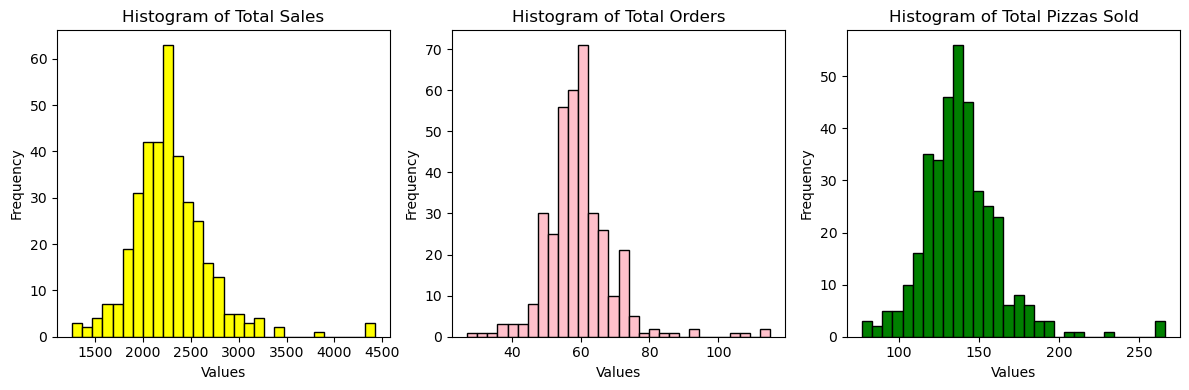

In [7]:
# Creating subplots with multiple histograms
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
 
axes[0].hist(sales_df_result['Total Sales'], bins=30, color='Yellow', edgecolor='black')
axes[0].set_title('Histogram of Total Sales')
 
axes[1].hist(sales_df_result['Total Orders'], bins=30, color='Pink', edgecolor='black')
axes[1].set_title('Histogram of Total Orders')

axes[2].hist(sales_df_result['Total Pizzas Sold'], bins=30, color='Green', edgecolor='black')
axes[2].set_title('Histogram of Total Pizzas Sold')
 
# Adding labels and title
for ax in axes:
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
 
# Adjusting layout for better spacing
plt.tight_layout()
 
# Display the figure
plt.show()

The time series plots for each variable does not indicate any strong trend or seasonality apparent within the data. It would be appropriate to confirm it with statistical tests, but the tests will more than likely confirm it. Also, I do not find it shocking that the plots look similar for the most part. The variables should be strongly correlated since sales are dependent on the total number of orders and pizzas sold. I decided to inspect this with a scatter plot matrix and my suspicions were confirmed. Hence, the variables "Total Orders" and "Total Pizzas Sold" were dropped from the rest of the analysis.

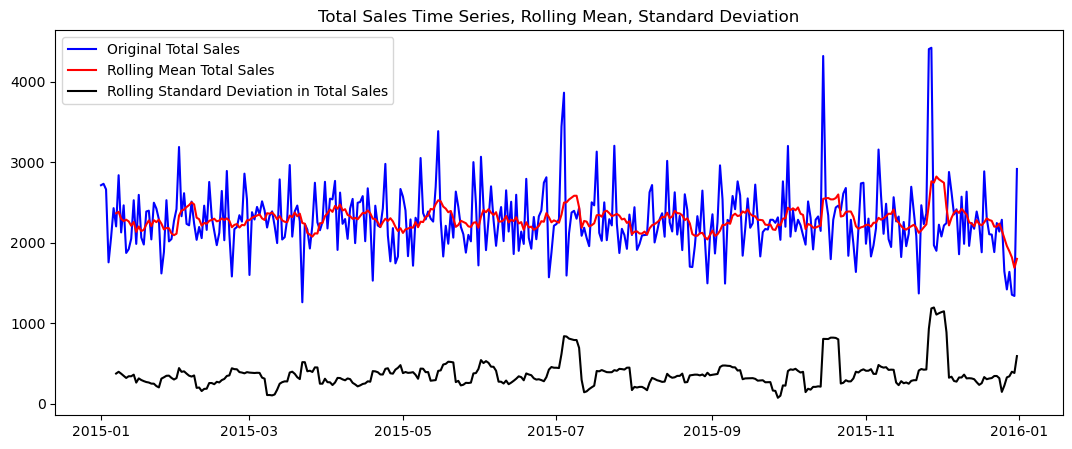

In [8]:
rolling_mean = sales_df_result.rolling(7).mean()
rolling_std = sales_df_result.rolling(7).std()
fig = plt.subplots(figsize=(13,5))
plt.plot(sales_df_result['Total Sales'], color="blue",label="Original Total Sales")
plt.plot(rolling_mean['Total Sales'], color="red", label="Rolling Mean Total Sales")
plt.plot(rolling_std['Total Sales'], color="black", label = "Rolling Standard Deviation in Total Sales")
plt.title("Total Sales Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

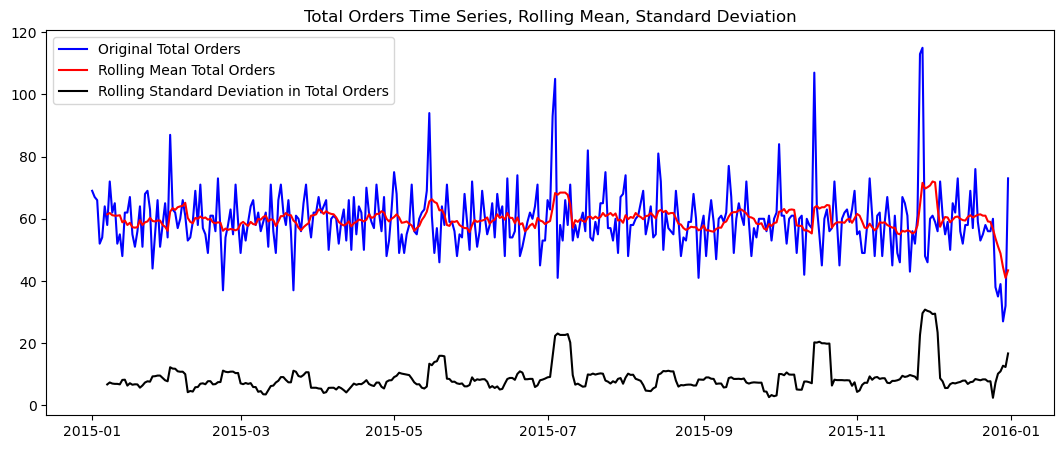

In [9]:
# Create a time series graph for total orders.
fig = plt.subplots(figsize=(13,5))
plt.plot(sales_df_result['Total Orders'], color="blue",label="Original Total Orders")
plt.plot(rolling_mean['Total Orders'], color="red", label="Rolling Mean Total Orders")
plt.plot(rolling_std['Total Orders'], color="black", label = "Rolling Standard Deviation in Total Orders")
plt.title("Total Orders Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

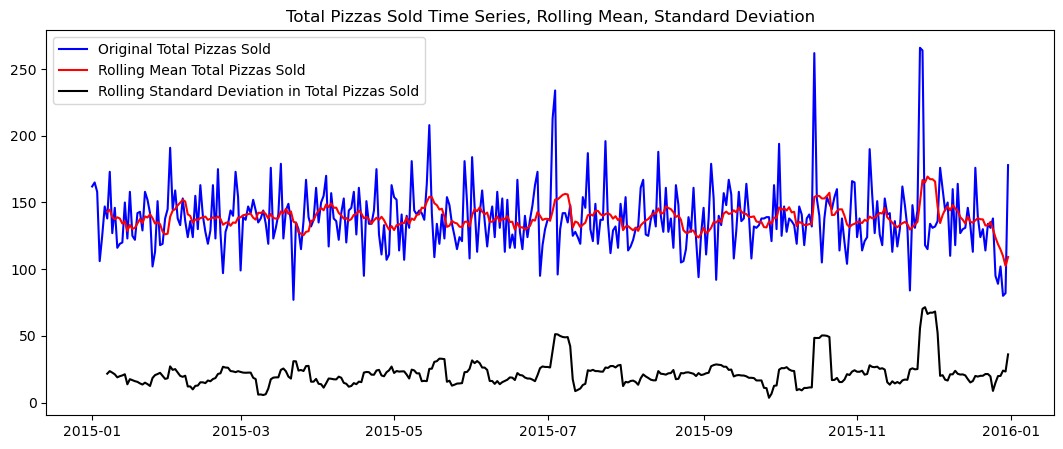

In [10]:
# Create a time series graph for total pizzas sold.
fig = plt.subplots(figsize=(13,5))
plt.plot(sales_df_result['Total Pizzas Sold'], color="blue",label="Original Total Pizzas Sold")
plt.plot(rolling_mean['Total Pizzas Sold'], color="red", label="Rolling Mean Total Pizzas Sold")
plt.plot(rolling_std['Total Pizzas Sold'], color="black", label = "Rolling Standard Deviation in Total Pizzas Sold")
plt.title("Total Pizzas Sold Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

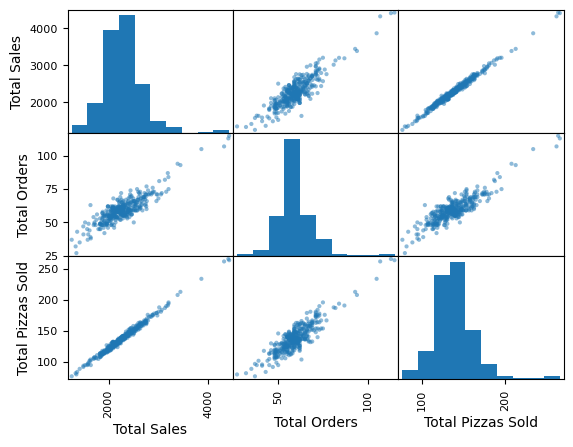

In [11]:
# Create a scatter plot matrix of the dataset for "Total Sales", "Total Orders", "Total Pizzas Sold".
features = ['Total Sales', 'Total Orders', 'Total Pizzas Sold']
scatter_matrix(sales_df_result[features])
plt.show()

### Research Question 1: Does the data exhibit stationary or nonstationary behavior?

This next step will determine whether the "Total Sales" exhibit any trend or seasonality within the data. This step will use the Augmented Dickey-Fuller (ADF) statistical test to determine whether it does. It is common practice to use this test. However, it is important to note that this test really determines whether a unit root is present within the time series. If the time series has a unit root, then it is nonstationary, implying that there exists trend or seasonality within the data. This would indicate that the data will need to be transformed. 

In other words, this section is testing the following hypothesis:
- H_{0}: The time series data is nonstationary (it has a unit root).
- H_{a}: The time series data is stationary (it does not have a unit root).

According to the results shown below, the calculated p-value is 0.000009, which is  significant at the 1%, 5%, and 10% significance levels. Hence, we failed to reject the null hypothesis, indicating that the data appears to be stationary, so it will not have to undergo any transformations. 

In [12]:
# Create a data frame containing only the total sales for each date.
X = sales_df_result['Total Sales']

# Apply the adfuller() method to X to apply the ADF test. Display the results showing 
# the calculated statistic, p-value, and the critical values at the 1%, 5%, and 10% 
# significance levels.
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.204883
p-value: 0.000009
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


#### Prepping the training and test datasets

Since the total sales variable do not exhibit any seasonality or trend within its data, it does not have to undergo any transformations. Instead, it can be prepped for the next stage, model building. This project will utilize the observations for the first eleven months (representing January 2015 - November 2015) as the training partition, while the last month (December 2015) will be paritioned as the testing set. Thus, the models will seek to determine the accuracy of its forecast for December 2015, which will be projected per day, when utilizing the sales data from January 2015 - November 2015 as the data for the models to be trained on. The following code shows how the data was split into the training and test partitions for this project.

In [13]:
# Split the dataset so that the first eleven months of data is allocated to training
# and the last month to the testing partition.
split_date = pd.Timestamp('2015-12-01')
df1 = sales_df_result['Total Sales']
train = df1.loc[:split_date]
test = df1.loc[split_date:]

# Print the number of values in the training and testing partitions.
print("We have", len(train), "train values")
print("We have", len(test), "test values")

We have 335 train values
We have 31 test values


### Research Question 2: Does an ARIMA or Simple ANN model forecast sales better?

#### Determining the optimal ARIMA model

Each model will be optimized using the Grid Search. Grid Search is a search procedure that can be used to optimize models by determining the optimal hyperparameter values for a model. This procedure allows the user to select the particular hyperparameters that will be optimized for a model. It does not have to select the optimal value for each hyperparameter option (e.g., hyperparameters that are not part of the grid search).

For the ARIMA model, the values of p, d, and q will be filled with a combination of 0, 1, 2, 3, and 4 to form a tuple, (p,d,q), that will be used by the order hyperparameter for the ARIMA model. The values of p, d, and q represent the following:
- p: The order of the auto-regressive (AR) model (e.g., the number of lag observations).
- d: The degree of differencing (ideally, this value should be 0 since the ADF test reveal that the series was stationary, so there was no differencing applied to the series).
- q: The order of the moving average (MA) model. Essentially the size of the "window" function over the time series data.

The following code block will create each model (based on the combinations of the order parameter) and store the resulting AIC value into a data frame along with the values of p, d, and q that produced the model. 

In [14]:
# Create the variables p,d,q as a list with values 0,1,2, and 3.
# Then, create the pdq to contain the combinations of p,d,q as a tuple value. 
# pdq will be used as the value passed to the order hyperparameter in the ARIMA() method.
p = d = q = range(0,5)
pdq = list(itertools.product(p,d,q))

# Create a blank results list to store the choices of pdq.
results_list = []

# Create a nested for loop that will create a model for each choice of pdq.
# The AIC results of each model are stored into the results list.
for param in pdq:
    try:
        mod = ARIMA(train, order=param, enforce_stationarity=False, enforce_invertibility=False)
        results = mod.fit()
        results_list.append([param, results.aic])
    except:
        continue

/Users/cjlouci/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/cjlouci/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/cjlouci/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/cjlouci/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/cjlouci/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was 

The following code block determines that the model with the order parameter tuple of (4, 0, 4) produces the model with the smallest AIC value.

In [15]:
# Convert the results list into a dataframe. Print the row that has the lowest AIC.
# This row corresponds to the best performing model.
results_df = pd.DataFrame(results_list, columns=['Parameter', 'AIC'])
print(results_df[results_df.AIC == results_df.AIC.min()])

     Parameter          AIC
104  (4, 0, 4)  4804.632843


The following code block will create the optimal ARIMA model and display the results. According to the results, each term is statistically significant since they have a p-value less than 0.05. However, this model might be a little problematic according to the Ljung-Box, Heteroscedasticity, and Jarque-Bera test values. The Ljung-Box test indicates that the errors might not be white noise (p-value of 0.05 indicates that we cannot reject null hypothesis of errors being white noise). The Heteroscedasticity test indicates that the residuals show variance (p-value of 0.00 indicates that we cannot reject null hypothesis of constant variance in residuals). The Jarque-Bera test indicates the errors are not normally distributed (p-value of 0.00 indicate that we reject the null hypothesis that the errors are normally distributed).

The code after the following code block creates diagnostic plots for the model. These plots are used to help diagnose the significance of the model. The first plot, Standardized residual, does not appear to have any clear pattern. However, the plot does indicate non-constant variance, confirming the results from the White's test. The KDE curve is similar to the normal curve in the "Histogram plus estimated density" plot, which is good. The KDE curve does have a higher peak than the normal curve, but the overall shape and location of the curve coincides with the normal curve. However, it is important to note the height of the bins since this indicates that the distribution is skewed (bins on the right side of the mean is taller than the bins on the left side of the mean). The Normal Q-Q plot does indicate that there is a little problem since there are a few data points (at the ends of the plots) that do not fall on the straight line, but most of the points do which is good. The Correlogram (ACF plot) does not show any lag greater than 0 to be significant since all of the points fall within the band. 

For the purpose of the project, we will continue to use this as the optimal model even though there are some problems with the model. This model was determined to be the optimal model for the data based on the Grid Search procedure.

In [16]:
# Create the optimal ARIMA model and display the results.
ARIMA_mod = ARIMA(train, order=(4, 0, 4), enforce_stationarity=False, enforce_invertibility=False)
ARIMA_results = ARIMA_mod.fit()
ARIMA_results.summary()

/Users/cjlouci/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/cjlouci/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/cjlouci/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Total Sales   No. Observations:                  335
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -2392.316
Date:                Tue, 30 Jul 2024   AIC                           4804.633
Time:                        18:46:23   BIC                           4842.624
Sample:                    01-01-2015   HQIC                          4819.787
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2295.3514     28.483     80.586      0.000    2239.525    2351.178
ar.L1          0.8008      0.005    162.015      0.000       0.791       0.811
ar.L2         -1.4444      0.006   -229.291      0.000      -1.457      -1.432
ar.L3          0.7996      0.005    173.185      0.000       0.791       0.809
ar.L4         -1.0085      0.004   -224.275      0.000      -1.017      -1.000
ma.L1         -0.7805      0.046    -16.814      0.000      -0.871      -0.689
ma.L2          1.4234      0.065     22.000      0.000       1.297       1.550
ma.L3         -0.7745      0.066    -11.734      0.000      -0.904      -0.645
ma.L4          0.9869      0.080     12.312      0.000       0.830       1.144
sigma2      1.356e+05   1.33e+04     10.224      0.000     1.1e+05    1.62e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               891.58
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               2.17   Skew:                             1.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

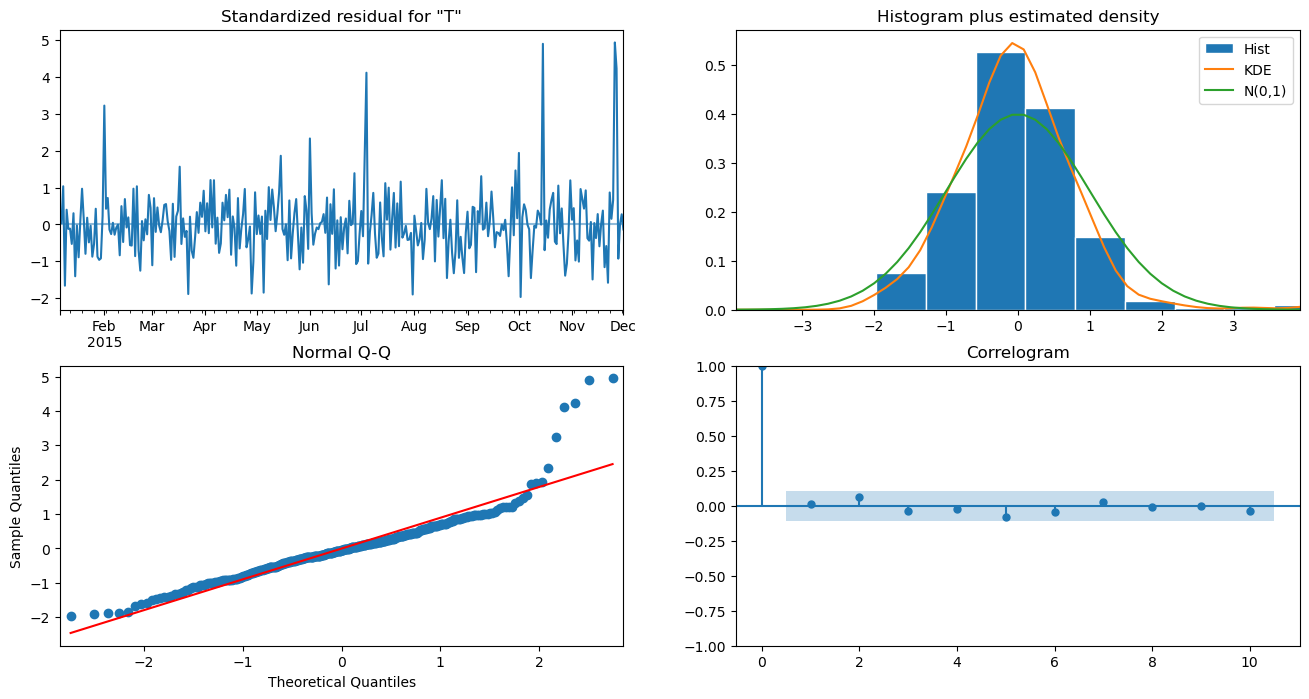

In [17]:
ARIMA_results.plot_diagnostics(figsize=(16,8))
plt.show()

The following code blocks produces the predictions for the training and test partitions of the dataset. These predictions are used to calculate the RMSE for the training and test sets. According to the results, the training RMSE is \\$337.39, while the test RMSE is \\$524.48. The training RMSE is low, indicating that it does fit the data. However, it is likely that the model fits the training data too well since the training RMSE is so low compared to the test RMSE. The large RMSE for the test set is problematic since it does not indicate strong performance. Ideally, it should be closer to the Training score.

Also, the predictions for December 2015 using the ARIMA model is stored into a new data frame called forecasted sales. This data frame contains the original observed values for each date too. This data frame will be used later on for further exploration of the results.

In [18]:
train_pred = ARIMA_results.get_prediction(0, 334).predicted_mean
test_pred = ARIMA_results.get_prediction(335,365).predicted_mean

forecasted_sales = pd.DataFrame(test)
forecasted_sales['ARIMA Predictions'] = test_pred.values

In [36]:
print("The RMSE score on the Train set is:\t{:0.3f}".format(np.sqrt(mean_squared_error(train, train_pred))))
print("The RMSE score on the Test set is:\t{:0.3f}".format(np.sqrt(mean_squared_error(test, test_pred))))

The RMSE score on the Train set is:	337.391
The RMSE score on the Test set is:	524.478


#### Determining the optimal Simple ANN model

A Simple ANN model will be the second model to be used for the project. This model will be used to compare its forecasts with the ARIMA model. The construction of this model will be similar to the ARIMA model case, meaning that it will utilize Grid Search to find the optimal hyperparameters for the model. However, the data will need to be transformed before being fed into a neural network. This is a common technique to utilize with data being fed into neural networks since unscaled variables can impact the performance of neural networks significantly. Hence, the following code block shows how the data is transformed for this portion.

In [20]:
train_processed = sales_df_result.iloc[:, 0:1].values
train_processed = train_processed[0:334:1]
test_processed = sales_df_result.iloc[:, 0:1].values
test_processed = test_processed[333:365:1]

scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train_processed)
test_sc = scaler.transform(test_processed)

X_train = train_sc[:-1]
y_train = train_sc[1:]
X_test = test_sc[:-1]
y_test = test_sc[1:]

The Grid Search will be more complicated for the Simple ANN model since the number of hyperparameters to be tested increases to 4, but the number of options decreases to 3 for each hyperparameter. Regardless, it will still have to test more models. The Grid Search for the Simple ANN model will test the following hyperparameters:
- Optimizers: Algorithms used to update the weights of a neural network during training. Responsibile for finding the set of weights that minimizes the loss function (mean squared error). The choices are 'adam', 'sgd', and 'adamax'.
- Activations: The mathematical function to apply to the neural network. The choices are 'relu', 'sigmoid', 'tanh'.
- Epochs: The number of times that the model should be fit to the data to learn the patterns to create the model. This can impact overfitting. The choices are 25, 50, 100.
- Batches: Defines the number of samples to be included in each pass. The choices are 1, 5, 10.

In [21]:
# Grid search parameter values
optimizers = ['adam', 'sgd', 'adamax']
activations = ['relu', 'sigmoid', 'tanh']
epochs = [25, 50, 100]
batches = [1, 5, 10]
model_score_results = []

for optimizer in optimizers:
    for epoch in epochs:
        for batch in batches:
            for activation in activations:
                simple_nn_model = Sequential()
                simple_nn_model.add(Dense(12, input_dim=1, activation = activation))
                simple_nn_model.add(Dense(1))
                simple_nn_model.compile(loss='mean_squared_error', optimizer=optimizer)
                history = simple_nn_model.fit(X_train, y_train, epochs=epoch, batch_size = batch, verbose = 1, shuffle=False)
                y_train_pred_nn = simple_nn_model.predict(X_train)
                y_train_pred_nn2 = scaler.inverse_transform(y_train_pred_nn)
                y_train2 = scaler.inverse_transform(y_train)
                training_model_score = np.sqrt(mean_squared_error(y_train2, y_train_pred_nn2))
                model_score_results.append([optimizer, activation, epoch, batch, training_model_score])

Epoch 1/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 186us/step - loss: 0.0713 
Epoch 2/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 164us/step - loss: 0.0494
Epoch 3/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step - loss: 0.0480
Epoch 4/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 175us/step - loss: 0.0475
Epoch 5/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 169us/step - loss: 0.0474
Epoch 6/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 167us/step - loss: 0.0473
Epoch 7/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step - loss: 0.0472
Epoch 8/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step - loss: 0.0472
Epoch 9/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step - loss: 0.0472
Epoch 10/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 168us/step - loss: 0.0472
Epoch 11/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step - loss: 0.0472
Epoch 12/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step - loss: 0.0472
Epoch 13/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step - loss: 0.0472
Epoch 14/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 175us/step - loss: 0.0472
Epoch 15/25
333/333 ━━━━━━━━

According to the results shown from the below code block, the optimal hyperparameter values are 'adam' for the Optimizer, 'relu' for the Activation Function, 100 for the number of epochs, and one for the batch size. This produced a model with a mean squared error of 392.29.

In [22]:
model_score_results_df = pd.DataFrame(model_score_results, columns=["Optimizer", 'Activation Function', 'Number of Epochs', 'Batch Size', 'Score'])
print(model_score_results_df[model_score_results_df.Score == model_score_results_df.Score.min()])

   Optimizer Activation Function  Number of Epochs  Batch Size       Score
18      adam                relu               100           1  392.287965


The following code block creates the optimal Simple ANN model and then produces the RMSE scores for the training and testing sets. It is important to note that the predictions had to be transformed before the RMSE could be calculated. The choice was to produce scores in the same scale as the ARIMA model predictions. According to the second code block, the training RMSE score was \\$396.75 and the testing RMSE score was \\$421.60.

In [23]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - loss: 0.0681     
Epoch 2/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step - loss: 0.0531
Epoch 3/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step - loss: 0.0498
Epoch 4/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step - loss: 0.0485
Epoch 5/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step - loss: 0.0479
Epoch 6/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step - loss: 0.0476
Epoch 7/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step - loss: 0.0474
Epoch 8/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step - loss: 0.0473
Epoch 9/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step - loss: 0.0472
Epoch 10/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step - loss: 0.0472
Epoch 11/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step - loss: 0.0471
Epoch 12/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step - loss: 0.0471
Epoch 13/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step - loss: 0.0470
Epoch 14/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step - loss: 0.0470
Epoch 15/1

In [24]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
y_pred_test_nn2 = scaler.inverse_transform(y_pred_test_nn)
y_train2 = scaler.inverse_transform(y_train)
y_test2 = scaler.inverse_transform(y_test)
print("The RMSE score on the Train set is:\t{:0.3f}".format(np.sqrt(mean_squared_error(y_train2, y_train_pred_nn2))))
print("The RMSE score on the Test set is:\t{:0.3f}".format(np.sqrt(mean_squared_error(y_test2, y_pred_test_nn2))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
The RMSE score on the Train set is:	396.749
The RMSE score on the Test set is:	421.600


#### Evaluating the Forecasting Performance: Closing Remarks 

From the results, the Simple ANN model performed better according to the test RMSE scores. The ARIMA model had a test RMSE score of \\$524.48, while the Simple ANN had a test RMSE score of \\$421.60. This is a significant improvement in forecasting accuracy, which leads to believe that the Simple ANN model is the superior model. 

I was curious about the performance of the forecasted values versus the actual values, so I decided to create a visualization showing the time series data of the forecasted values and actual values for December 2015. The visualizations reveal information that cannot be inferred by the results of the model by the evaluation metric. According to the visualization, the ARIMA and Simple ANN models did not forecast sales well. However, the ARIMA model seems to perform better (indicated by the red line) at predicting the trend of sales than the Simple ANN model (indicated by the green line). The Simple ANN model maintains a roughly straight line, indicating predictions around a mean value with little variation. The ARIMA model does not produce a straight line, but a line with upward and downward trends like the line for the actual sales (blue). There does seem to be some closeness in predictions at times with the ARIMA model because of how parts of the plot contains roughly the same shape/trend. This would lead me to believe the ARIMA model should have performed better. 

The reason why it might not have performed as well as the Simple ANN model is that the month of December experienced a significant drop in sales at the end of the month. The ARIMA model did not predict that significant of a drop, which impacted its performance. It wasn't able to capture that noise. However, I am not shocked since I have personal experience in the industry and would not think the model could have anticipated that big of a drop with the limited history (no December sale data to go on at all). It might have performed better if it had at least one set of training observations for sales in December. 

Text(0.5, 1.0, 'Time Series Plot of Total Sales')

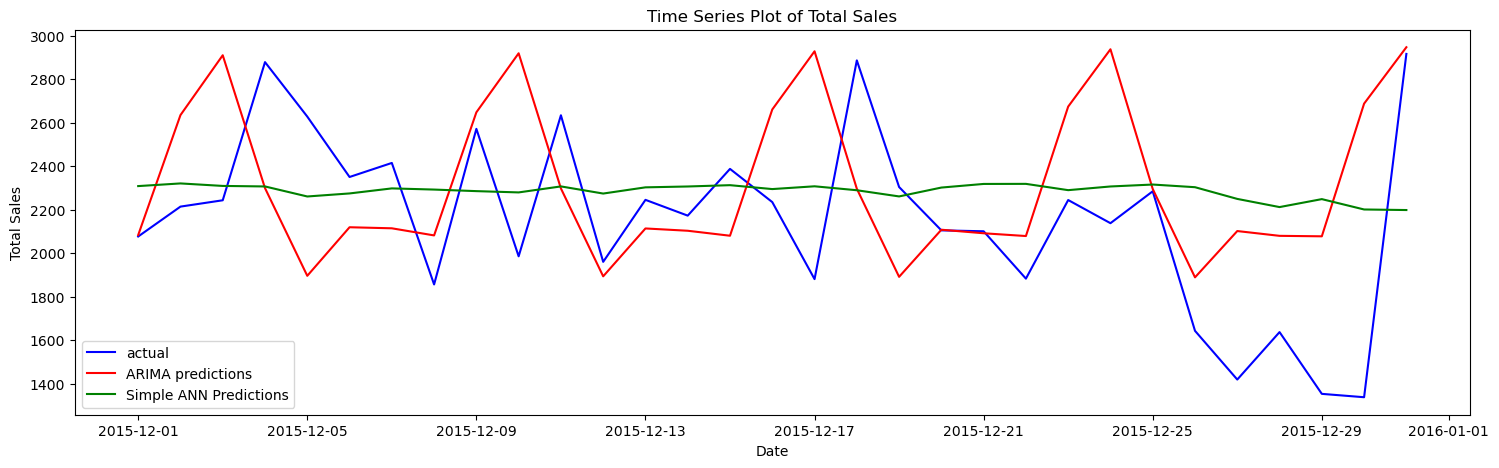

In [32]:
forecasted_sales['Simple ANN Model Predictions'] = y_pred_test_nn2


fig, ax = plt.subplots(figsize=(18,5))

ax.plot(forecasted_sales['Total Sales'], 'b-', label = 'actual')
ax.plot(forecasted_sales['ARIMA Predictions'], 'r-', label = 'ARIMA predictions')
ax.plot(forecasted_sales['Simple ANN Model Predictions'], 'g-', label = 'Simple ANN Predictions')
ax.legend(loc="lower left")
ax.set_xlabel('Date')
ax.set_ylabel('Total Sales')
ax.set_title('Time Series Plot of Total Sales')

The other thing item I wanted to examine was the percent errors for the forecasted sales for each model for December 2015. According to the code block below, the Simple ANN model has a percent error of 5.77%, while the ARIMA model has a percent error of 7.39%. This confirms that the Simple ANN produced a more accurate forecast for December 2015 since the monthly predictions deviated the least from the actual sales. However, the visualizations show that this model is not effective at predicting sales on a daily basis. The ARIMA model appears to be more effective at times since it is able to capture the variation in sales better than the Simple ANN model, indicating an ARIMA model might be more effective with more data. Specifically, it might perform better if it had at least one month of sales history from December. December's sales pattern might be too volatile that including this data will allow the model to produce a model that captures this noise better, which then impacts its predictions. Regardless, the Simple ANN produces a better forecast for December 2015 than the ARIMA model.

In [35]:
# Determing the total amount of sales for the month of December for the predictions
# and actual values
simple_ann_sum = forecasted_sales['Simple ANN Model Predictions'].sum()
arima_sum = forecasted_sales['ARIMA Predictions'].sum()
total_sum = forecasted_sales['Total Sales'].sum()

# Calculating Error Percentages
ann_difference_per = ((simple_ann_sum - total_sum) / total_sum) * 100
arima_difference_per = ((arima_sum - total_sum) / total_sum) * 100

print("The forecast percent error using the Simple ANN model is:\t{:0.2f}".format(ann_difference_per))
print("The forecast percent error using the ARIMA model is:\t{:0.2f}".format(arima_difference_per))

The forecast percent error using the Simple ANN model is:	5.77
The forecast percent error using the ARIMA model is:	7.39


Thank you for reading this document! I hope you found my findings to be meaningful and hopefully you have learned something from reading about it.

Carl